# JPR 2025 HandsOn IA: Classificação Binária de Radiografias de Tórax

**Data:** 27 de abril de 2025
**Versão do Notebook:** 1.0
**Link para o repositório:** https://github.com/jnather/JPR-2025-Handson-IA

## Objetivos
- Treinar uma Rede Neural Convolucional (CNN) didática para diferenciar radiografias de tórax Normais vs. com Opacidade.
- Avaliar a performance do modelo no conjunto de teste (loss, acurácia, matriz de confusão, curvas ROC/PR, intervalos de confiança).
- Publicar e testar o modelo em produção por meio de uma interface web interativa (Gradio) para inferência em casos novos.  

## Requisitos
- Python 3.7+  
- TensorFlow ≥ 2.x e Keras  
- Bibliotecas: `numpy`, `scikit-learn`, `matplotlib`, `gradio`, `opencv-python`, `pillow`  
- Ambiente Colab ou máquina local com GPU (opcional, mas recomendado)  

## Autores
- Julio Cesar Nather Junior, MD, MSc (https://www.linkedin.com/in/julio-nather-049618181/)
- Felipe Kitamura, MD, PhD (https://www.linkedin.com/in/felipekitamura/)

## Descrição Geral do Notebook
Este notebook está organizado em seções sequenciais para conduzir todo o workflow de um projeto de Deep Learning aplicado à radiologia:
1. **Preparação do Ambiente** – Instalação de dependências e configuração de paths  
2. **Ingestão e Pré-processamento** – Download do subset do Kaggle, definição de `train/val/test`, otimização de pipeline (cache, shuffle, prefetch)  
3. **Construção e Treinamento do Modelo** – Data augmentation, definição da arquitetura CNN, callbacks, cálculo de pesos de classe e execução do `model.fit`  
4. **Avaliação de Performance** – Cálculos de métricas completas (classification report, matriz de confusão, ROC, Precision-Recall, intervalos de confiança via bootstrap)  
5. **Deploy e Inferência** – Carregamento do modelo salvo, definição de funções de pré-processamento, criação de interface Gradio com exemplos embaralhados e CSS customizado  
6. **Testes Interativos** – Interface web para subir novas imagens e obter predições instantâneas  

Vamos começar!


In [1]:
"""
JPR 2025 Handson IA

Tutorial: Classificação binária de radiografias de tórax com TensorFlow/Keras
e aplicação do modelo treinado na prática (Deploy)

Autores:
Julio Cesar Nather Junior (https://nia.hcrp.usp.br/)
Felipe Kitamura (https://www.linkedin.com/in/felipekitamura/)

-----------------------------------------------------------------------------

Estrutura geral do script
1.  Bibliotecas e configurações iniciais
2.  Cópia do conjunto de dados (Kaggle → máquina local do Colab)
3.  Criação dos conjuntos de treino, validação e teste
4.  Otimizações de pipeline (cache, prefetch)
5.  Cálculo de pesos de classe para lidar com desbalanceamento caso exista
6.  Camada de aumento de dados (data-augmentation)
7.  Definição do modelo CNN
8.  Callbacks (ajuste de LR, early stopping, checkpoint etc.)
9.  Treinamento do modelo
10. Avaliação do modelo
11. Deploy do modelo

-----------------------------------------------------------------------------
"""

# ────────────────────────── 0. Instala dependências ──────────────────────────
# • Executar só na primeira vez para instalar Gradio, OpenCV, Pillow e NumPy
!pip -q install gradio opencv-python pillow numpy

# ───────────────────────── 1. Bibliotecas e configurações ──────────────────────────
import pathlib, shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
import numpy as np
from sklearn.utils import class_weight
import zipfile
import os

import kagglehub

# Download dos arquivos do dataset
path = kagglehub.dataset_download("jnather/jpr-2025-handson-ia")
print(f"Arquivos salvos em {path}.")

# Mover todos os arquivos baixados para a pasta atual
src_dir = pathlib.Path(path)
dst_dir = pathlib.Path(os.getcwd())

# Copia todo o conteúdo de src_dir para dst_dir, sobrescrevendo o que já existir
shutil.copytree(
    src=str(src_dir),
    dst=str(dst_dir),
    dirs_exist_ok=True  # permite sobrescrever o conteúdo existente :contentReference[oaicite:4]{index=4}
)

DST = pathlib.Path("/content/dataset/dataset_sample")

# Ativamos *mixed precision* (usa float16 onde possível) e o compilador XLA → mais rápido
#mixed_precision.set_global_policy('mixed_float16')
#tf.config.optimizer.set_jit(True)

# Hiperparâmetros básicos
DATA_DIR   = str(DST)     # caminho da pasta com subpastas/labels
IMG_SIZE   = (224, 224)   # resolução para redimensionamento
BATCH_SIZE = 64
EPOCHS     = 100
SEED       = 42           # garante reprodutibilidade

# ───────────────────────── 2. Carregamento dos dados ───────────────────────────────
"""
`image_dataset_from_directory` cria automaticamente rótulos (labels) a partir das
subpastas do diretório raiz. Usamos `validation_split` para reservar 30 % dos
arquivos para validação; daqui a pouco dividiremos essa parte em VAL e TEST.
"""
train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"   # rótulos 0/1
)

val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

# ───────────────────────── 3. Split: VAL_DS e TEST_DS ──────────────────────────────
"""
Dividimos o conjunto de validação em duas metades:
- VAL_DS  → usado durante o treino para *early stopping* e ajuste de LR
- TEST_DS → usado só no final, para avaliar desempenho “cego”
"""
val_batches = tf.data.experimental.cardinality(val_ds)
TEST_DS = val_ds.take(val_batches // 2)  # primeira metade
VAL_DS  = val_ds.skip(val_batches // 2)  # segunda metade

# ───────────────────────── 4. Otimização do pipeline ───────────────────────────────
AUTOTUNE = tf.data.AUTOTUNE  # TensorFlow escolhe o paralelismo ideal

def optimize_train(ds):
    """
    • cache()     → mantêm o dataset pré-processado na RAM sempre que possível
    • shuffle()   → embaralha as amostras (importante para o treino)
    • prefetch()  → sobrepõe a preparação de dados à computação no GPU
    """
    return ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)

def optimize_eval(ds):
    return ds.cache().prefetch(tf.data.AUTOTUNE)

TRAIN_DS = optimize_train(train_ds)
VAL_DS   = optimize_eval(VAL_DS)
TEST_DS  = optimize_eval(TEST_DS)

# ─────────────────── 5. Cálculo de pesos para classes desbalanceadas ───────────────
"""
Se uma classe tiver muito mais imagens que a outra, o modelo tende a “emprestar”
esse viés. Os pesos de classe fazem a função de perda penalizar mais os erros na
classe minoritária.
"""
# Concatena todos os rótulos em um único vetor 1-D
y_all = np.concatenate([y.numpy() for _, y in TRAIN_DS]).reshape(-1)

# Calcula pesos balanceados: quanto menor a classe, maior o peso
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_all),
    y=y_all
)
class_weight_dict = dict(enumerate(weights))   # {0: w0, 1: w1}

# ───────────────────────── 6. Aumento de dados ─────────────────────────────────────
"""
O *data-augmentation* cria “versões alternativas” das imagens
(espelhamento, rotação, zoom etc.) para que o modelo generalize melhor.
"""
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")

# ───────────────────────── 7. Definição do modelo CNN ──────────────────────────────
"""
Rede Convolucional simples, construída do zero para fins didáticos:
Conv → MaxPool (repete 4x) → Flatten → Dense → Dropout → Saída Sigmóide
"""
model = keras.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),     # 3 canais RGB
    layers.Rescaling(1./255),                # normaliza pixels [0-1]
    augment,                                 # camada de aumento de dados
    layers.Conv2D(32,  (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,  (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),                     # evita overfitting
    layers.Dense(1, activation="sigmoid")    # probabilidade da classe positiva
], name="JPR_2025_HandsON_cnn_chestxray")

model.compile(
    optimizer='adam',
    loss = keras.losses.BinaryCrossentropy(label_smoothing=0.05), # mitiga over-confidence, melhora calibração e tolera ruído de rótulos
    metrics=['accuracy']
)

# ───────────────────────── 8. Callbacks úteis ──────────────────────────────────────
"""
Callbacks automatizam ajustes durante o treino:
• ReduceLROnPlateau  → diminui LR quando `val_loss` estaciona
• EarlyStopping      → interrompe o treino se não houver melhora
• ModelCheckpoint    → salva o melhor modelo (baseado em `val_accuracy`)
• CSVLogger          → grava histórico em CSV (fácil de plotar depois)
"""
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5', monitor='val_accuracy',
    save_best_only=True, mode='max', verbose=1
)

csv_logger = tf.keras.callbacks.CSVLogger(
    filename='training_log.csv', append=False
)

callbacks = [reduce_lr, early_stop, checkpoint, csv_logger]

# ─────────── 9. Cálculo automático de steps_per_epoch ───────────
# tf.data.experimental.cardinality() devolve o número de batches em cada Dataset
train_batches = tf.data.experimental.cardinality(TRAIN_DS).numpy()
val_batches   = tf.data.experimental.cardinality(VAL_DS).numpy()

print(f"Batches de treino por época:      {train_batches}")
print(f"Batches de validação por época: {val_batches}")


# ───────────────────────── 10. Treinamento ──────────────────────────────────────────
"""
Opcional:
• steps_per_epoch = 100 → limita quantos lotes de treino por época
  (útil para datasets enormes; deixe `None` se quiser percorrer tudo).
• validation_steps = 50  → mesma ideia para validação.
• class_weight        → aplica os pesos calculados para corrigir o desequilíbrio.
"""

history = model.fit(
    TRAIN_DS,
    epochs=EPOCHS,
    steps_per_epoch=train_batches,     # percorre todos os batches de treino
    validation_data=VAL_DS,
    validation_steps=val_batches,      # percorre todos os batches de validação
    callbacks=callbacks,
    class_weight=class_weight_dict
)

model.save('best_model.h5')

print("Treinamento concluído! O melhor modelo foi salvo em 'best_model.h5'.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


100%|██████████| 137M/137M [00:07<00:00, 20.4MB/s]

Extracting files...


Arquivos salvos em /root/.cache/kagglehub/datasets/jnather/jpr-2025-handson-ia/versions/2.
Found 2000 files belonging to 2 classes.
Using 1400 files for training.
Found 2000 files belonging to 2 classes.
Using 600 files for validation.
Batches de treino por época:      22
Batches de validação por época: 5
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5124 - loss: 0.7107
Epoch 1: val_accuracy improved from -inf to 0.77857, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.5155 - loss: 0.7092 - val_accuracy: 0.7786 - val_loss: 0.5511 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7519 - loss: 0.5469
Epoch 2: val_accuracy did not improve from 0.77857
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7533 - loss: 0.5456 - val_accuracy: 0.7750 - val_loss: 0.5027 - learning_rate: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8206 - loss: 0.4786
Epoch 3: val_accuracy improved from 0.77857 to 0.81786, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8206 - loss: 0.4784 - val_accuracy: 0.8179 - val_loss: 0.4636 - learning_rate: 0.0010
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8131 - loss: 0.4745
Epoch 4: val_accuracy did not improve from 0.81786
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8140 - loss: 0.4736 - val_accuracy: 0.7893 - val_loss: 0.4732 - learning_rate: 0.0010
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8245 - loss: 0.4472
Epoch 5: val_accuracy did not improve from 0.81786
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8247 - loss: 0.4469 - val_accuracy: 0.7500 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8194 - loss: 0.4538
Epoch 6: val_accuracy did not improve from 0.81786
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8201 - loss: 0.4529 - val_accuracy: 0.8143 - val_loss: 0.4307 - learning_rate: 0.0010
Epoch 7/100
22/22 ━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8307 - loss: 0.4260 - val_accuracy: 0.8357 - val_loss: 0.4052 - learning_rate: 0.0010
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8389 - loss: 0.3934
Epoch 10: val_accuracy did not improve from 0.83571
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8395 - loss: 0.3933 - val_accuracy: 0.8357 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8424 - loss: 0.4043
Epoch 11: val_accuracy improved from 0.83571 to 0.83929, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8422 - loss: 0.4045 - val_accuracy: 0.8393 - val_loss: 0.4096 - learning_rate: 0.0010
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8764 - loss: 0.3753
Epoch 12: val_accuracy did not improve from 0.83929
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8756 - loss: 0.3760 - val_accuracy: 0.8286 - val_loss: 0.4169 - learning_rate: 0.0010
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8500 - loss: 0.4102
Epoch 13: val_accuracy improved from 0.83929 to 0.84286, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8499 - loss: 0.4097 - val_accuracy: 0.8429 - val_loss: 0.4017 - learning_rate: 0.0010
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8593 - loss: 0.3928
Epoch 14: val_accuracy improved from 0.84286 to 0.85000, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.8594 - loss: 0.3924 - val_accuracy: 0.8500 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8711 - loss: 0.3739
Epoch 15: val_accuracy did not improve from 0.85000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8710 - loss: 0.3739 - val_accuracy: 0.8393 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8855 - loss: 0.3582
Epoch 16: val_accuracy did not improve from 0.85000
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8849 - loss: 0.3590 - val_accuracy: 0.8286 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8710 - loss: 0.3637
Epoch 17: val_accuracy did not improve from 0.85000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8708 - loss: 0.3643 - val_accuracy: 0.8393 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 18/100
22/22 

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9009 - loss: 0.3198 - val_accuracy: 0.8571 - val_loss: 0.3525 - learning_rate: 2.0000e-04
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8993 - loss: 0.3056
Epoch 34: val_accuracy improved from 0.85714 to 0.87500, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.8989 - loss: 0.3064 - val_accuracy: 0.8750 - val_loss: 0.3713 - learning_rate: 2.0000e-04
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9068 - loss: 0.3053
Epoch 35: val_accuracy did not improve from 0.87500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9065 - loss: 0.3059 - val_accuracy: 0.8500 - val_loss: 0.3576 - learning_rate: 2.0000e-04
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9107 - loss: 0.3186
Epoch 36: val_accuracy did not improve from 0.87500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9104 - loss: 0.3186 - val_accuracy: 0.8500 - val_loss: 0.3567 - learning_rate: 2.0000e-04
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9020 - loss: 0.3133
Epoch 37: val_accuracy did not improve from 0.87500
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9019 - loss: 0.3135 - val_accuracy: 0.8571 - val_loss: 0.3621 - learning_rate: 2.0000e-04
Epo

Treinamento concluído! O melhor modelo foi salvo em 'best_model.h5'.



1️⃣ Avaliando o modelo no conjunto de TESTE…
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.8413 - loss: 0.3895
   ➤ Loss de teste:   0.3958
   ➤ Acurácia de teste: 85.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

2️⃣ Relatório de classificação:
              precision    recall  f1-score   support

      normal     0.8425    0.8311    0.8367       148
   opacidade     0.8563    0.8663    0.8613       172

    accuracy                         0.8500       320
   macro avg     0.8494    0.8487    0.8490       320
weighted avg     0.8499    0.8500    0.8499       320

3️⃣ Matriz de confusão (contagem de verdadeiros vs. previstos):
[[123  25]
 [ 23 149]]


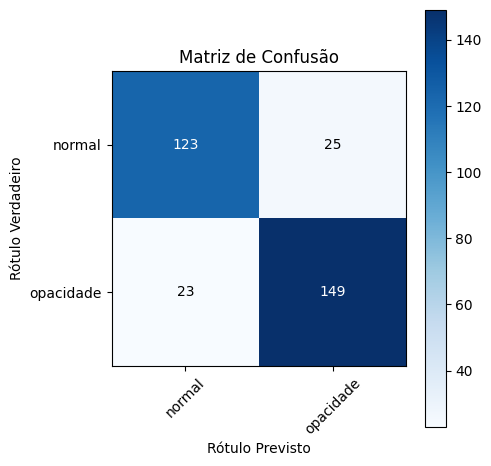

4️⃣ Plotando Curva ROC (desempenho geral do modelo):


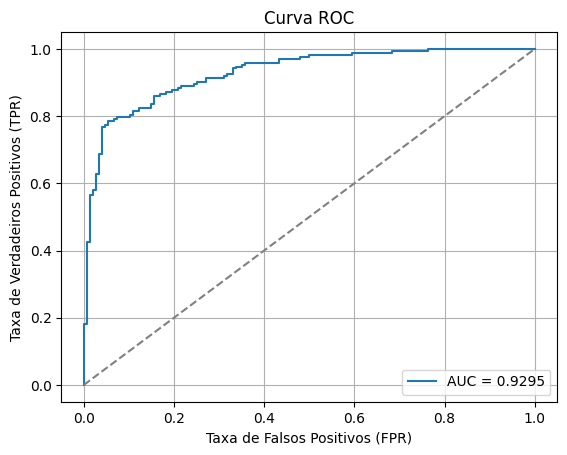

5️⃣ Plotando Curva Precisão-Recall:


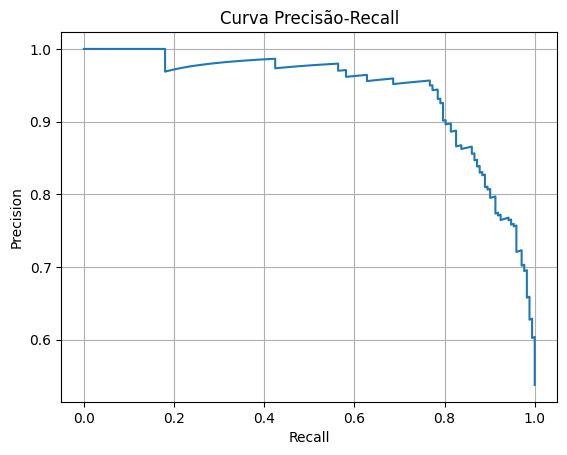

6️⃣ Exibindo algumas imagens do teste com previsões:
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step 


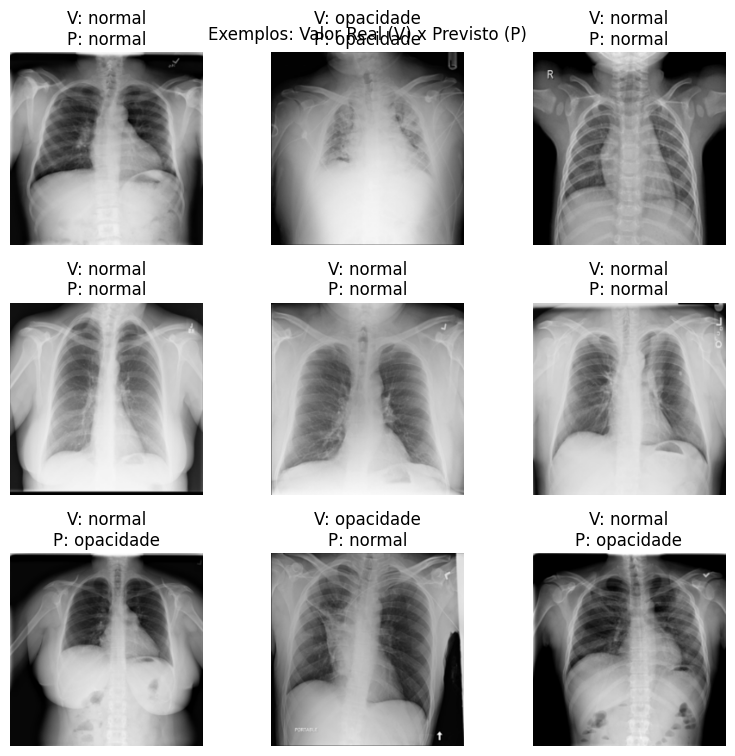

7️⃣ Mostrando evolução de loss e acurácia durante o treino:


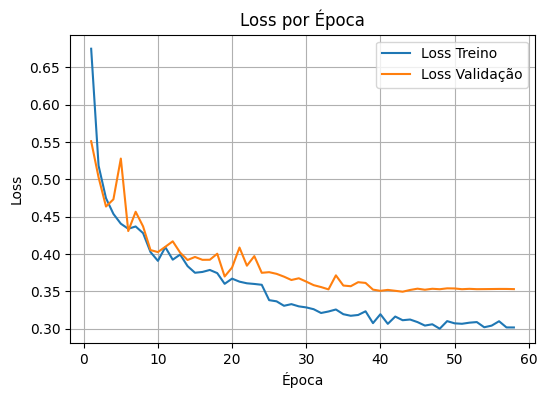

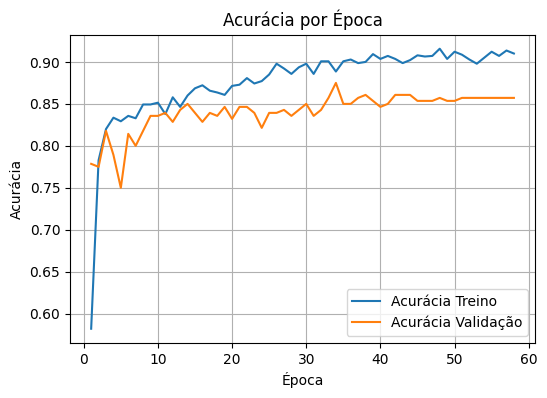

AUC = 0.930  (95% CI 0.901–0.956)


In [2]:
# ──────────────────────────────── IMPORTAÇÕES ────────────────────────────────
# Biblioteca para trabalho com números e vetores
import numpy as np
# Biblioteca para criar gráficos
import matplotlib.pyplot as plt
# Métricas de avaliação de modelos
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# ─────────────────────────── 1. AVALIAÇÃO GERAL ────────────────────────────
print("\n1️⃣ Avaliando o modelo no conjunto de TESTE…")
# model.evaluate já imprime loss e acurácia diretamente
loss, accuracy = model.evaluate(TEST_DS, verbose=1)
print(f"   ➤ Loss de teste:   {loss:.4f}")
print(f"   ➤ Acurácia de teste: {accuracy:.2%}")

# ─────────────────────────── 2. PREPARAR DADOS PARA RELATÓRIOS ────────────────────────────
# 2.1 Extrai todos os rótulos verdadeiros em um vetor 1-D
y_true = np.concatenate([y.numpy() for _, y in TEST_DS], axis=0)
# 2.2 Gera as probabilidades preditas pelo modelo
y_pred_probs = model.predict(TEST_DS).ravel()
# 2.3 Converte probabilidades em classes (0 ou 1) usando limiar de 0.5
y_pred = (y_pred_probs >= 0.5).astype(int)

# ─────────────────────────── 3. RELATÓRIO DE CLASSIFICAÇÃO ────────────────────────────
print("\n2️⃣ Relatório de classificação:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["normal", "opacidade"],
    digits=4
))

# ─────────────────────────── 4. MATRIZ DE CONFUSÃO ────────────────────────────
print("3️⃣ Matriz de confusão (contagem de verdadeiros vs. previstos):")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# 4.1 Desenha a matriz de confusão como um mapa de calor
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.colorbar()
labels = ["normal", "opacidade"]
plt.xticks([0,1], labels, rotation=45)
plt.yticks([0,1], labels)
plt.ylabel("Rótulo Verdadeiro")
plt.xlabel("Rótulo Previsto")
# Escreve o número de casos em cada célula
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# ─────────────────────────── 5. CURVA ROC ────────────────────────────
print("4️⃣ Plotando Curva ROC (desempenho geral do modelo):")
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # linha de referência aleatória
plt.title("Curva ROC")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ─────────────────────────── 6. CURVA PRECISÃO-RECALL ────────────────────────────
print("5️⃣ Plotando Curva Precisão-Recall:")
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)

plt.figure()
plt.plot(recall, precision)
plt.title("Curva Precisão-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# ─────────────────────────── 7. EXEMPLOS DE IMAGENS ────────────────────────────
print("6️⃣ Exibindo algumas imagens do teste com previsões:")
# Pega apenas um lote de imagens e rótulos
for imagens, labels in TEST_DS.take(1):
    probs_lote = model.predict(imagens).ravel()
    break

# Converte probabilidades em classes
classes_lote = (probs_lote >= 0.5).astype(int)

# Mostra 9 imagens em uma grade 3×3
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for idx, ax in enumerate(axes.flat):
    img = imagens[idx].numpy().astype("uint8")
    verdadeiro = labels[idx].numpy()
    previsto   = classes_lote[idx]
    # Coloca legenda com Valor Real (V) e Previsto (P)
    ax.imshow(img)
    ax.set_title(f"V: {'opacidade' if verdadeiro==1 else 'normal'}\n"
                 f"P: {'opacidade' if previsto==1 else 'normal'}")
    ax.axis("off")

plt.suptitle("Exemplos: Valor Real (V) x Previsto (P)", y=0.92)
plt.tight_layout()
plt.show()

# ─────────────────────────── 8. CURVAS DE TREINAMENTO ────────────────────────────
print("7️⃣ Mostrando evolução de loss e acurácia durante o treino:")
# history é o retorno de model.fit(...)
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
epochs     = range(1, len(train_loss) + 1)

# 8.1 Loss
plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, label='Loss Treino')
plt.plot(epochs, val_loss,   label='Loss Validação')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 8.2 Acurácia
plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, label='Acurácia Treino')
plt.plot(epochs, val_acc,   label='Acurácia Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
from sklearn.metrics import roc_auc_score

# Cálculo de intervalo de confiança; pode ser feito também para outras métricas.
def boot(metric, y_true, y_prob, n=1000, alpha=0.95, seed=42):
    rng = np.random.default_rng(seed)
    N = len(y_true)
    scores = []
    for _ in range(n):
        idx = rng.choice(N, size=N, replace=True)
        scores.append(metric(y_true[idx], y_prob[idx]))
    lower, upper = np.percentile(scores, [(1-alpha)/2*100, (1+alpha)/2*100])
    return np.mean(scores), (lower, upper)

# Uso:
auc, (lo, hi) = boot(roc_auc_score, y_true, y_pred_probs, n=1000, alpha=0.95)
print(f"AUC = {auc:.3f}  (95% CI {lo:.3f}–{hi:.3f})")


In [3]:
import shutil
import pathlib
import glob
import random
import os

# ────────────────────────── 1) Carrega o modelo ──────────────────────────
# • Se já não estiver em memória, carrega 'best_model.h5' ou lança erro
from tensorflow.keras.models import load_model

if 'model' not in globals():
    model_path = 'best_model.h5'
    if os.path.exists(model_path):
        model = load_model(model_path)
    else:
        raise FileNotFoundError(f"Arquivo '{model_path}' não encontrado")

# ────────────────────────── 3) Importações principais ──────────────────────────
import gradio as gr       # Para interface web
import numpy as np       # Manipulação de arrays
import cv2               # Redimensionamento e padding
from PIL import Image    # Leitura e conversão de imagens

# ────────────────────────── 4) Parâmetro de imagem ──────────────────────────
IMG_SIZE = 224  # Lado do quadrado de entrada para o modelo

# ────────────────────────── 5) Funções de pré‐processamento ──────────────────────────
def normalize_0_255(img: np.ndarray) -> np.ndarray:
    """
    Normaliza os pixels entre 0 e 255.
    Se todos os pixels forem iguais, retorna zeros.
    """
    mi, ma = img.min(), img.max()
    if ma == mi:
        return np.zeros_like(img, dtype=np.float32)
    return ((img - mi) / (ma - mi) * 255.0).astype(np.float32)

def resize_with_padding(img: np.ndarray, size: int = IMG_SIZE) -> np.ndarray:
    """
    Redimensiona mantendo proporção e adiciona bordas pretas
    para formar uma imagem quadrada de lado 'size'.
    """
    h, w = img.shape
    scale = size / max(h, w)
    nh, nw = int(h * scale), int(w * scale)
    img_rs = cv2.resize(img, (nw, nh))
    top = (size - nh) // 2
    bottom = size - nh - top
    left = (size - nw) // 2
    right = size - nw - left
    return cv2.copyMakeBorder(img_rs, top, bottom, left, right,
                              borderType=cv2.BORDER_CONSTANT, value=0)

def preprocess_common(image: Image.Image) -> np.ndarray:
    """
    1) Converte para escala de cinza ('L')
    2) Transforma em float32 e normaliza 0–255
    3) Aplica resize + padding
    4) Repete canal para RGB e adiciona batch dimension
    """
    gray = image.convert('L')
    arr = np.array(gray, dtype=np.float32)
    arr = normalize_0_255(arr)
    arr = resize_with_padding(arr)
    arr = np.stack([arr, arr, arr], axis=-1)
    return np.expand_dims(arr, axis=0)

# ────────────────────────── 6) Função de inferência ──────────────────────────
def inferir_imagem(img: Image.Image):
    """
    Recebe PIL Image, aplica preprocessamento e retorna
    dicionário com probabilidades para 'Normal' e 'Opacidade'.
    """
    x = preprocess_common(img)
    prob = float(model.predict(x)[0][0])
    return {"Normal": 1 - prob, "Opacidade": prob}

# ────────────────────────── 7) Lista de exemplos embaralhada ──────────────────────────
# • Coleta todas as PNGs de 'normal' e 'opacidade' e embaralha
example_paths = (
    glob.glob('/content/dataset_sample_test/dataset_sample_test/normal/*.png') +
    glob.glob('/content/dataset_sample_test/dataset_sample_test/opacidade/*.png')
)
random.shuffle(example_paths)

# CSS para forçar exatamente 4 colunas (2 fileiras de 4 miniaturas)
custom_css = """
#example-grid .gr-examples {
    display: grid !important;
    grid-template-columns: repeat(4, 1fr) !important;
    gap: 10px !important;
}
"""

# ────────────────────────── 8) Monta e lança a interface ──────────────────────────
with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("## 🚑 Classificador de Radiografias de Tórax")
    gr.Markdown("Clique em uma miniatura ou faça upload para ver a predição.")

    with gr.Row():
        input_img = gr.Image(type="pil", label="Radiografia (PNG/JPEG)")
        output_lbl = gr.Label(num_top_classes=2, label="Predição")

    gr.Examples(
        examples=example_paths,       # lista já embaralhada
        inputs=input_img,             # conecta ao input
        outputs=output_lbl,           # conecta ao output
        cache_examples=False,         # sempre roda inferência nova
        examples_per_page=8,          # 8 exemplos = 2 fileiras de 4
        elem_id="example-grid",       # id usado pelo CSS acima
        label="📑 Exemplos"
    )

    input_img.change(inferir_imagem, inputs=input_img, outputs=output_lbl)

# Lança o app com link público no Colab
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ae075d7d9c19c118a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
